# 自洽场迭代流程

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/bud-primordium/AtomSCF/blob/main/docs/source/tutorials/03-scf.ipynb)

## 学习目标

- 理解自洽场（SCF）循环的核心逻辑
- 掌握密度泛函理论（DFT-LDA）的实现
- 观察能量收敛过程并分析轨道能量

## SCF 循环原理

多电子体系的波函数通过迭代求解自洽方程：

1. **初始猜测**：给定初始电子密度 $n_0(r)$
2. **构造有效势**：$V_{\mathrm{eff}}[n] = V_{\mathrm{ext}} + V_{\mathrm{H}}[n] + V_{\mathrm{xc}}[n]$
3. **求解轨道**：本征值问题得到新的波函数 $\psi_i$
4. **更新密度**：$n_{\mathrm{new}} = \sum_i f_i |\psi_i|^2$
5. **检查收敛**：若 $|E_{\mathrm{new}} - E_{\mathrm{old}}| < \epsilon$，结束；否则混合密度后返回步骤 2

## 理论基础：自洽场迭代算法

Kohn-Sham 方程的自洽求解流程：

### 迭代步骤

1. **初始化**：设定初始密度 $n^{(0)}(r)$（类氢猜测）
2. **构造有效势**：

$$V_{\text{eff}}^{(k)}[n] = V_{\text{ext}} + V_H[n^{(k)}] + V_{xc}[n^{(k)}]$$

其中 Hartree 势：

$$V_H(r) = \int \frac{n(r')}{|r-r'|}d^3r'$$

3. **求解本征问题**：

$$\left[-\frac{1}{2}\nabla^2 + V_{\text{eff}}^{(k)}\right]\psi_i = \varepsilon_i\psi_i$$

4. **更新密度**：

$$n^{(k+1)}(r) = \sum_i f_i |\psi_i(r)|^2$$

5. **密度混合**（加速收敛）：

$$n^{(k+1)} \leftarrow \alpha n^{(k+1)} + (1-\alpha)n^{(k)}$$

6. **收敛判据**：$\|n^{(k+1)} - n^{(k)}\| < \epsilon$ 或 $|E^{(k+1)} - E^{(k)}| < \epsilon$

**代码实现**：`run_lsda_pz81(cfg)` 函数执行完整 SCF 循环


In [1]:
# 环境配置
import sys

if "google.colab" in sys.modules:
    !pip install -q git+https://github.com/bud-primordium/AtomSCF.git

In [2]:
# 配置中文字体（避免乱码）
import matplotlib.pyplot as plt
import matplotlib

# 跨平台中文字体配置
matplotlib.rcParams['font.sans-serif'] = [
    'Arial Unicode MS',      # macOS
    'WenQuanYi Micro Hei',  # Linux
    'SimHei',                # Windows
    'DejaVu Sans'            # Fallback
]
matplotlib.rcParams['axes.unicode_minus'] = False

# 清除字体缓存（重要！）
try:
    import matplotlib.font_manager as fm
    fm._load_fontmanager(try_read_cache=False)
except Exception:
    pass


In [3]:
import numpy as np
import matplotlib.pyplot as plt
from atomscf.grid import radial_grid_linear
from atomscf.scf import SCFConfig, run_lsda_pz81

plt.style.use('seaborn-v0_8-darkgrid')
plt.rcParams['figure.figsize'] = (12, 5)

## Al 原子自洽计算

铝（Z=13）电子组态：1s² 2s² 2p⁶ 3s² 3p¹

In [4]:
# 生成网格
r, w = radial_grid_linear(n=800, rmin=1e-5, rmax=30.0)

# 配置 Al 原子（Z=13，自动使用 default_occupations）
cfg = SCFConfig(
    Z=13,
    r=r,
    w=w,
    maxiter=50,
    tol=1e-6,
    mix_alpha=0.3,  # 密度混合系数
    spin_mode="LSDA",  # 自旋极化
)

print("配置信息:")
print(f"  原子: Al (Z={cfg.Z})")
print(f"  网格点数: {len(r)}")
print(f"  收敛阈值: {cfg.tol:.0e} Hartree")
print(f"  自旋模式: {cfg.spin_mode}")

配置信息:
  原子: Al (Z=13)
  网格点数: 800
  收敛阈值: 1e-06 Hartree
  自旋模式: LSDA


## 运行 LSDA-PZ81 自洽计算

使用 Perdew-Zunger 1981 交换关联泛函：

In [5]:
# 执行自洽计算
result = run_lsda_pz81(cfg)

print("\n收敛结果:")
print(f"  收敛状态: {'成功' if result.converged else '失败'}")
print(f"  迭代次数: {result.iterations}")

# 安全访问能量（可能为 None）
E_total = result.energies.get('E_total', 0.0) if result.energies else 0.0
E_kin = result.energies.get('E_kin', 0.0) if result.energies else 0.0

print(f"  总能量: {E_total:.6f} Hartree")
print(f"  总能量: {E_total * 27.211:.3f} eV")

print("\n能量分解:")
print(f"  动能: {E_kin:.6f} Ha")
print(f"  外势能: {result.energies.get('E_ext', 0.0) if result.energies else 0.0:.6f} Ha")
print(f"  Hartree 能: {result.energies.get('E_H', 0.0) if result.energies else 0.0:.6f} Ha")
print(f"  交换关联能: {result.energies.get('E_xc', 0.0) if result.energies else 0.0:.6f} Ha")


收敛结果:
  收敛状态: 成功
  迭代次数: 39
  总能量: -221.217095 Hartree
  总能量: -6019.538 eV

能量分解:
  动能: 197.600072 Ha
  外势能: -517.952951 Ha
  Hartree 能: 112.211554 Ha
  交换关联能: 0.000000 Ha


## 轨道能量分析

输出所有占据轨道的本征能量：

In [6]:
from atomscf.occupations import default_occupations

# 获取 Al 的默认占据配置
occ_specs = default_occupations(cfg.Z)

print("轨道能量 (Hartree):")
print("\nl   轨道   占据数   能量 (Ha)     能量 (eV)")
print("-" * 55)

for spec in occ_specs:
    l = spec.l
    n_idx = spec.n_index
    spin = spec.spin
    occ = spec.f_per_m * (2 * l + 1)  # 总占据数
    
    # 获取对应的能量（使用字符串 "up" 或 "down"）
    energies_l_spin = result.eps_by_l_sigma.get((l, spin), [])
    
    if n_idx < len(energies_l_spin):
        eps = energies_l_spin[n_idx]
        label = spec.label if hasattr(spec, 'label') else f"{n_idx+1}{'spdf'[l]}"
        print(f"{l}   {label:6s}   {occ:>5.1f}    {eps:>10.6f}    {eps*27.211:>10.3f}")

轨道能量 (Hartree):

l   轨道   占据数   能量 (Ha)     能量 (eV)
-------------------------------------------------------
0   1s_up      1.0    -46.898932     -1276.167
0   1s_down     1.0    -46.897319     -1276.123
0   2s_up      1.0     -3.166846       -86.173
0   2s_down     1.0     -3.165099       -86.126
1   2p_up      3.0     -2.083681       -56.699
1   2p_down     3.0     -2.081431       -56.638
0   3s_up      1.0     -0.232417        -6.324
0   3s_down     1.0     -0.220244        -5.993
1   3p_up      1.0     -0.080508        -2.191


## 电子密度可视化

绘制总电子密度分布：

/var/folders/dj/c_zzrj2d4tx4p72rfgyyk_3c0000gn/T/ipykernel_82421/1760923078.py:21: UserWarning: Glyph 24635 (\N{CJK UNIFIED IDEOGRAPH-603B}) missing from font(s) Arial.
  plt.tight_layout()
/var/folders/dj/c_zzrj2d4tx4p72rfgyyk_3c0000gn/T/ipykernel_82421/1760923078.py:21: UserWarning: Glyph 30005 (\N{CJK UNIFIED IDEOGRAPH-7535}) missing from font(s) Arial.
  plt.tight_layout()
/var/folders/dj/c_zzrj2d4tx4p72rfgyyk_3c0000gn/T/ipykernel_82421/1760923078.py:21: UserWarning: Glyph 23376 (\N{CJK UNIFIED IDEOGRAPH-5B50}) missing from font(s) Arial.
  plt.tight_layout()
/var/folders/dj/c_zzrj2d4tx4p72rfgyyk_3c0000gn/T/ipykernel_82421/1760923078.py:21: UserWarning: Glyph 23494 (\N{CJK UNIFIED IDEOGRAPH-5BC6}) missing from font(s) Arial.
  plt.tight_layout()
/var/folders/dj/c_zzrj2d4tx4p72rfgyyk_3c0000gn/T/ipykernel_82421/1760923078.py:21: UserWarning: Glyph 24230 (\N{CJK UNIFIED IDEOGRAPH-5EA6}) missing from font(s) Arial.
  plt.tight_layout()
/var/folders/dj/c_zzrj2d4tx4p72rfgyyk_3c0000gn/T/i

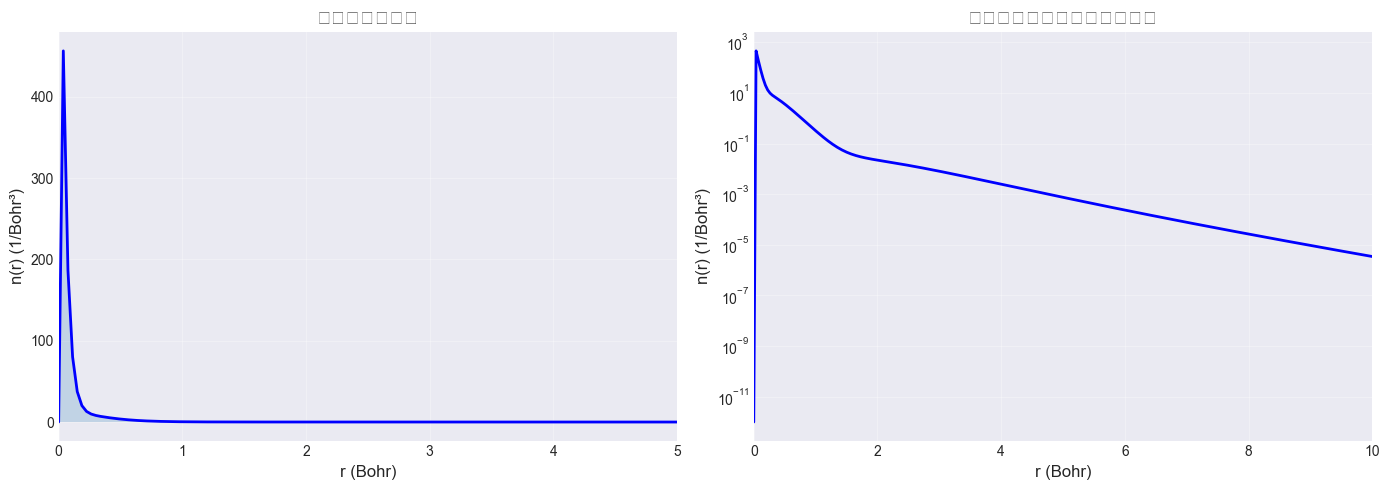


电子数积分: 13.00 (理论值: 13)


In [ ]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

# 左图：总密度（线性刻度）
n_total = result.n_up + result.n_dn
ax1.plot(r, n_total, 'b-', linewidth=2)
ax1.fill_between(r, 0, n_total, alpha=0.2)
ax1.set_xlabel('r (Bohr)', fontsize=12)
ax1.set_ylabel('n(r) (1/Bohr³)', fontsize=12)
ax1.set_title('总电子密度分布', fontsize=14)
ax1.set_xlim(0, 2)
ax1.grid(alpha=0.3)

# 右图：总密度（对数刻度）
ax2.semilogy(r, n_total + 1e-12, 'b-', linewidth=2)
ax2.set_xlabel('r (Bohr)', fontsize=12)
ax2.set_ylabel('n(r) (1/Bohr³)', fontsize=12)
ax2.set_title('总电子密度分布（对数刻度）', fontsize=14)
ax2.set_xlim(0, 2)
ax2.grid(alpha=0.3, which='both')

plt.tight_layout()
plt.show()

# 验证总电子数
N_total = np.sum(n_total * w * 4 * np.pi * r**2)
print(f"\n电子数积分: {N_total:.2f} (理论值: 13)")

## 占据轨道波函数

可视化所有占据轨道：

/var/folders/dj/c_zzrj2d4tx4p72rfgyyk_3c0000gn/T/ipykernel_82421/765150431.py:61: UserWarning: Glyph 36712 (\N{CJK UNIFIED IDEOGRAPH-8F68}) missing from font(s) Arial.
  plt.tight_layout()
/var/folders/dj/c_zzrj2d4tx4p72rfgyyk_3c0000gn/T/ipykernel_82421/765150431.py:61: UserWarning: Glyph 36947 (\N{CJK UNIFIED IDEOGRAPH-9053}) missing from font(s) Arial.
  plt.tight_layout()
/var/folders/dj/c_zzrj2d4tx4p72rfgyyk_3c0000gn/T/ipykernel_82421/765150431.py:61: UserWarning: Glyph 27874 (\N{CJK UNIFIED IDEOGRAPH-6CE2}) missing from font(s) Arial.
  plt.tight_layout()
/var/folders/dj/c_zzrj2d4tx4p72rfgyyk_3c0000gn/T/ipykernel_82421/765150431.py:61: UserWarning: Glyph 20989 (\N{CJK UNIFIED IDEOGRAPH-51FD}) missing from font(s) Arial.
  plt.tight_layout()
/var/folders/dj/c_zzrj2d4tx4p72rfgyyk_3c0000gn/T/ipykernel_82421/765150431.py:61: UserWarning: Glyph 25968 (\N{CJK UNIFIED IDEOGRAPH-6570}) missing from font(s) Arial.
  plt.tight_layout()
/var/folders/dj/c_zzrj2d4tx4p72rfgyyk_3c0000gn/T/ipyker

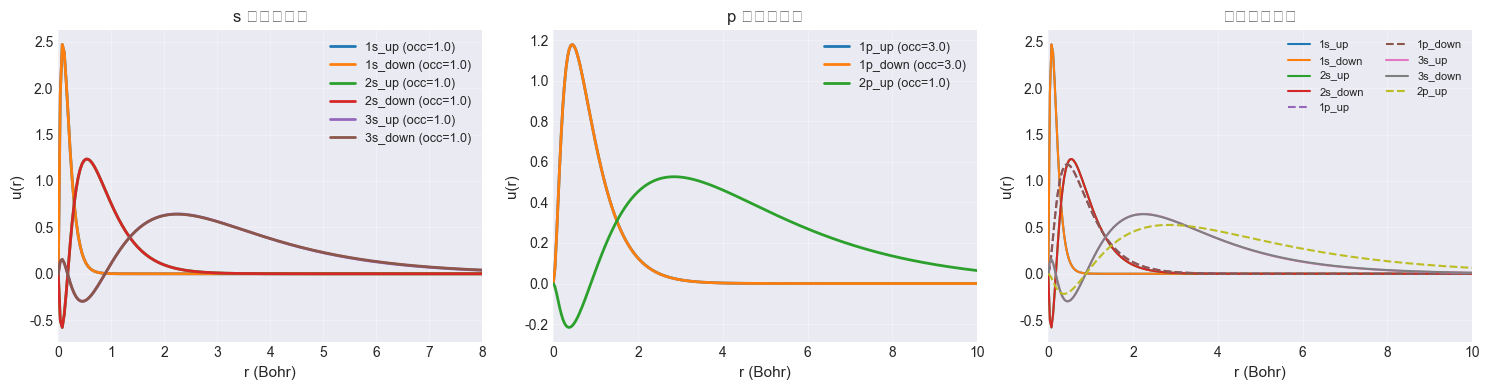

In [8]:
fig, axes = plt.subplots(1, 3, figsize=(15, 4))

# 获取占据配置
occ_specs = default_occupations(cfg.Z)

# 分组：s 和 p 轨道
s_orbitals = [spec for spec in occ_specs if spec.l == 0]
p_orbitals = [spec for spec in occ_specs if spec.l == 1]

# s 轨道
ax = axes[0]
for spec in s_orbitals:
    u_list = result.u_by_l_sigma.get((spec.l, spec.spin), [])
    if spec.n_index < len(u_list):
        u = u_list[spec.n_index]
        occ = spec.f_per_m * (2 * spec.l + 1)
        label = f"{spec.n_index+1}s_{spec.spin} (occ={occ:.1f})"
        ax.plot(r, u, label=label, linewidth=2)

ax.set_xlabel('r (Bohr)', fontsize=11)
ax.set_ylabel('u(r)', fontsize=11)
ax.set_title('s 轨道波函数', fontsize=12)
ax.set_xlim(0, 8)
ax.legend(fontsize=9)
ax.grid(alpha=0.3)

# p 轨道
ax = axes[1]
for spec in p_orbitals:
    u_list = result.u_by_l_sigma.get((spec.l, spec.spin), [])
    if spec.n_index < len(u_list):
        u = u_list[spec.n_index]
        occ = spec.f_per_m * (2 * spec.l + 1)
        label = f"{spec.n_index+1}p_{spec.spin} (occ={occ:.1f})"
        ax.plot(r, u, label=label, linewidth=2)

ax.set_xlabel('r (Bohr)', fontsize=11)
ax.set_ylabel('u(r)', fontsize=11)
ax.set_title('p 轨道波函数', fontsize=12)
ax.set_xlim(0, 10)
ax.legend(fontsize=9)
ax.grid(alpha=0.3)

# 所有轨道叠加
ax = axes[2]
for spec in occ_specs:
    u_list = result.u_by_l_sigma.get((spec.l, spec.spin), [])
    if spec.n_index < len(u_list):
        u = u_list[spec.n_index]
        label = f"{spec.n_index+1}{'spdf'[spec.l]}_{spec.spin}"
        linestyle = '-' if spec.l == 0 else '--'
        ax.plot(r, u, label=label, linewidth=1.5, linestyle=linestyle)

ax.set_xlabel('r (Bohr)', fontsize=11)
ax.set_ylabel('u(r)', fontsize=11)
ax.set_title('所有轨道叠加', fontsize=12)
ax.set_xlim(0, 10)
ax.legend(fontsize=8, ncol=2)
ax.grid(alpha=0.3)

plt.tight_layout()
plt.show()

## SCF 收敛特性

自洽迭代的收敛速度取决于：
- 密度混合系数 `mix_alpha`（0.2-0.5 较稳定）
- 初始猜测质量（类氢轨道 vs Thomas-Fermi）
- 系统复杂度（电子数、开壳层程度）

典型迭代次数：
- 轻元素（He, Li）：5-15 次
- 中等元素（Al, Si）：10-25 次
- 开壳层体系：15-40 次

## 下一步

- **[04-hartree-fock.ipynb](04-hartree-fock.ipynb)**：学习 HF 方法的显式交换积分
- **[05-dft-xc.ipynb](05-dft-xc.ipynb)**：深入理解 LDA 交换关联泛函